<a href="https://colab.research.google.com/github/manasdhir/loan-defaulter-classification/blob/main/Decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#importing necessary libraries

In [6]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics

In [7]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [50]:
df1=pd.read_csv("/content/drive/MyDrive/great learning/ensemble/credit.csv")
df1.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes


#EDA and data preprocessing

In [51]:
df1.shape

(1000, 17)

In [52]:
df1.describe()

,months_loan_duration,amount,percent_of_income,years_at_residence,age,existing_loans_count,dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [53]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   checking_balance      1000 non-null   object
 1   months_loan_duration  1000 non-null   int64 
 2   credit_history        1000 non-null   object
 3   purpose               1000 non-null   object
 4   amount                1000 non-null   int64 
 5   savings_balance       1000 non-null   object
 6   employment_duration   1000 non-null   object
 7   percent_of_income     1000 non-null   int64 
 8   years_at_residence    1000 non-null   int64 
 9   age                   1000 non-null   int64 
 10  other_credit          1000 non-null   object
 11  housing               1000 non-null   object
 12  existing_loans_count  1000 non-null   int64 
 13  job                   1000 non-null   object
 14  dependents            1000 non-null   int64 
 15  phone                 1000 non-null   o

a lot of columns are of object datatype so we need to convert them to int as decision trees do not work on object datatype

In [54]:
for i in list(df1.columns):
  if df1[i].dtype=="object":
    df1[i]==pd.Categorical(df1[i])

In [55]:
#checking value counts
for i in list(df1.columns):
  print(df1[i].value_counts())

unknown       394
< 0 DM        274
1 - 200 DM    269
> 200 DM       63
Name: checking_balance, dtype: int64
24    184
12    179
18    113
36     83
6      75
15     64
9      49
48     48
30     40
21     30
10     28
60     13
27     13
42     11
11      9
20      8
8       7
4       6
45      5
7       5
39      5
14      4
13      4
33      3
28      3
54      2
16      2
22      2
47      1
5       1
26      1
72      1
40      1
Name: months_loan_duration, dtype: int64
good         530
critical     293
poor          88
very good     49
perfect       40
Name: credit_history, dtype: int64
furniture/appliances    473
car                     337
business                 97
education                59
renovations              22
car0                     12
Name: purpose, dtype: int64
1478    3
1262    3
1258    3
1275    3
1393    3
       ..
1459    1
882     1
3758    1
1136    1
4576    1
Name: amount, Length: 921, dtype: int64
< 100 DM         603
unknown          183
100 - 500 DM

we will manually label encode these as they are ordinal data

In [56]:
replaceStruct = {
                "checking_balance":     {"< 0 DM": 1, "1 - 200 DM": 2 ,"> 200 DM": 3 ,"unknown":-1},
                "credit_history": {"critical": 1, "poor":2 , "good": 3, "very good": 4,"perfect": 5},
                 "savings_balance": {"< 100 DM": 1, "100 - 500 DM":2 , "500 - 1000 DM": 3, "> 1000 DM": 4,"unknown": -1},
                 "employment_duration":     {"unemployed": 1, "< 1 year": 2 ,"1 - 4 years": 3 ,"4 - 7 years": 4 ,"> 7 years": 5},
                "phone":     {"no": 1, "yes": 2 },
                "default":     {"no": 0, "yes": 1 }
                    }
oneHotCols=["purpose","housing","other_credit","job"]

In [57]:
df1=df1.replace(replaceStruct)
df1=pd.get_dummies(df1, columns=oneHotCols)
df1.shape

(1000, 29)

In [58]:
df1.head()

,checking_balance,months_loan_duration,credit_history,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,existing_loans_count,...,housing_other,housing_own,housing_rent,other_credit_bank,other_credit_none,other_credit_store,job_management,job_skilled,job_unemployed,job_unskilled
0,1,6,1,1169,-1,5,4,4,67,2,...,0,1,0,0,1,0,0,1,0,0
1,2,48,3,5951,1,3,2,2,22,1,...,0,1,0,0,1,0,0,1,0,0
2,-1,12,1,2096,1,4,2,3,49,1,...,0,1,0,0,1,0,0,0,0,1
3,1,42,3,7882,1,4,2,4,45,1,...,1,0,0,0,1,0,0,1,0,0
4,1,24,2,4870,1,3,3,4,53,2,...,1,0,0,0,1,0,0,1,0,0


In [59]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   checking_balance              1000 non-null   int64
 1   months_loan_duration          1000 non-null   int64
 2   credit_history                1000 non-null   int64
 3   amount                        1000 non-null   int64
 4   savings_balance               1000 non-null   int64
 5   employment_duration           1000 non-null   int64
 6   percent_of_income             1000 non-null   int64
 7   years_at_residence            1000 non-null   int64
 8   age                           1000 non-null   int64
 9   existing_loans_count          1000 non-null   int64
 10  dependents                    1000 non-null   int64
 11  phone                         1000 non-null   int64
 12  default                       1000 non-null   int64
 13  purpose_business              1000

now all columns are integers so they can be used to build a decision tree

#splitting data

In [61]:
x=df1.drop("default",axis=1)
x.shape

(1000, 28)

In [64]:
y=pd.DataFrame(df1["default"],columns=["default"])
y.shape

(1000, 1)

In [65]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=1)

#training decision tree with gini impurity without regularization

In [70]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1)#same can be dont with criterion as entropy
dTree.fit(x_train, y_train)

DecisionTreeClassifier(random_state=1)

##checking scores

In [68]:
dTree.score(x_train,y_train)

1.0

In [69]:
dTree.score(x_test,y_test)

0.6933333333333334

this is an overfit model as it has 1.0 accuracy for training data and 0.69 for testing we need to regularize it.

##visualizing the tree

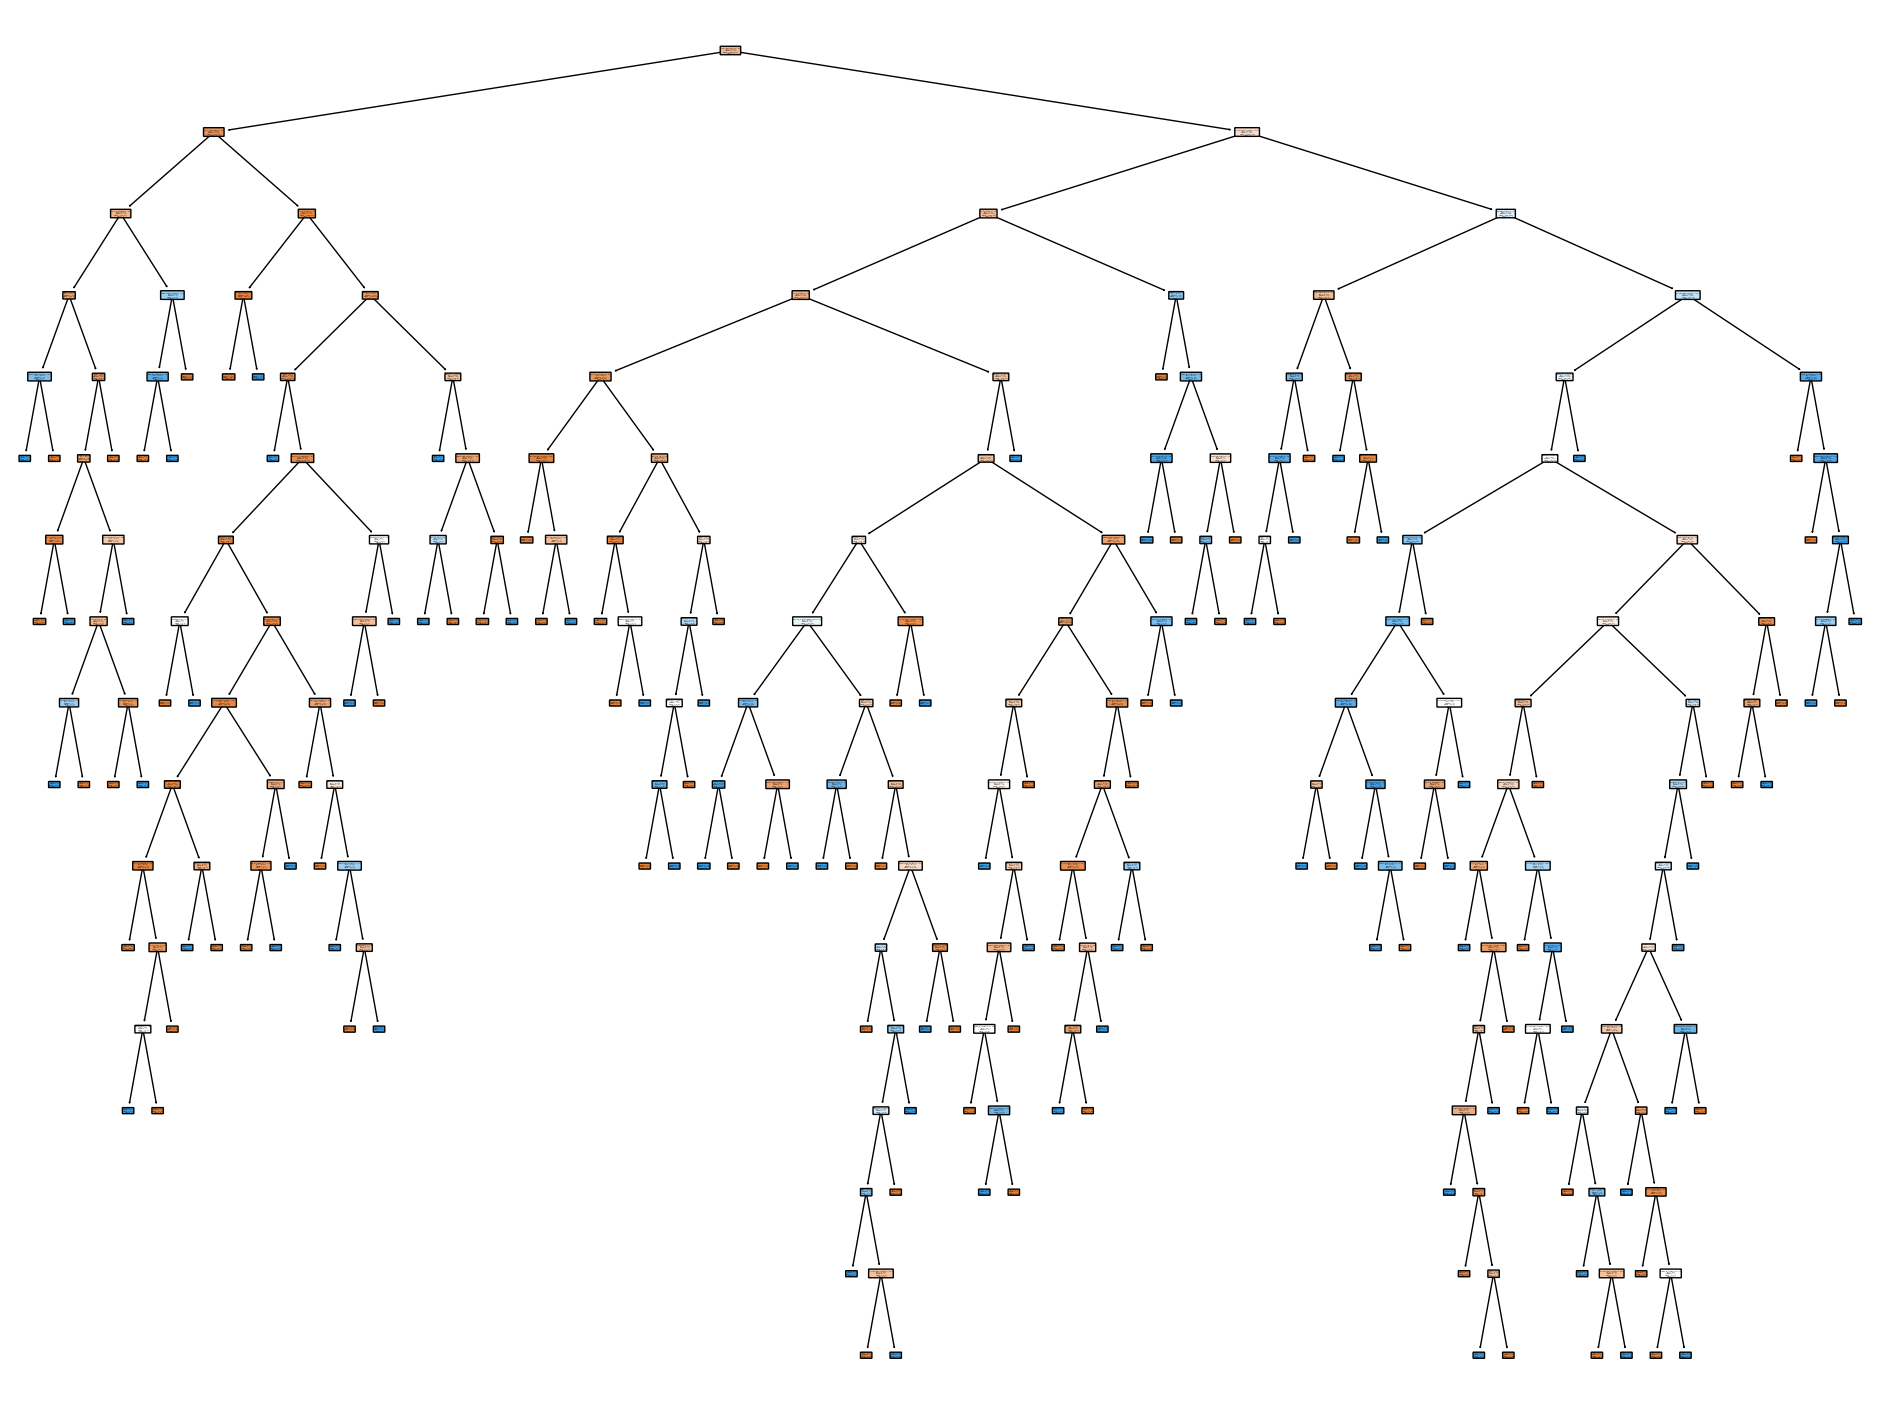

In [79]:
plt.figure(figsize=(24, 18))
plot_tree(dTree,feature_names=x.columns,class_names=["0","1"],filled=True,rounded=True)
plt.show()

#building decision tree with gini impurity with regularization

In [80]:
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1,max_depth=3)
dTree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

##checking scores

In [81]:
dTree.score(x_train,y_train)

0.7528571428571429

In [82]:
dTree.score(x_test,y_test)

0.7433333333333333

##visualizing the tree


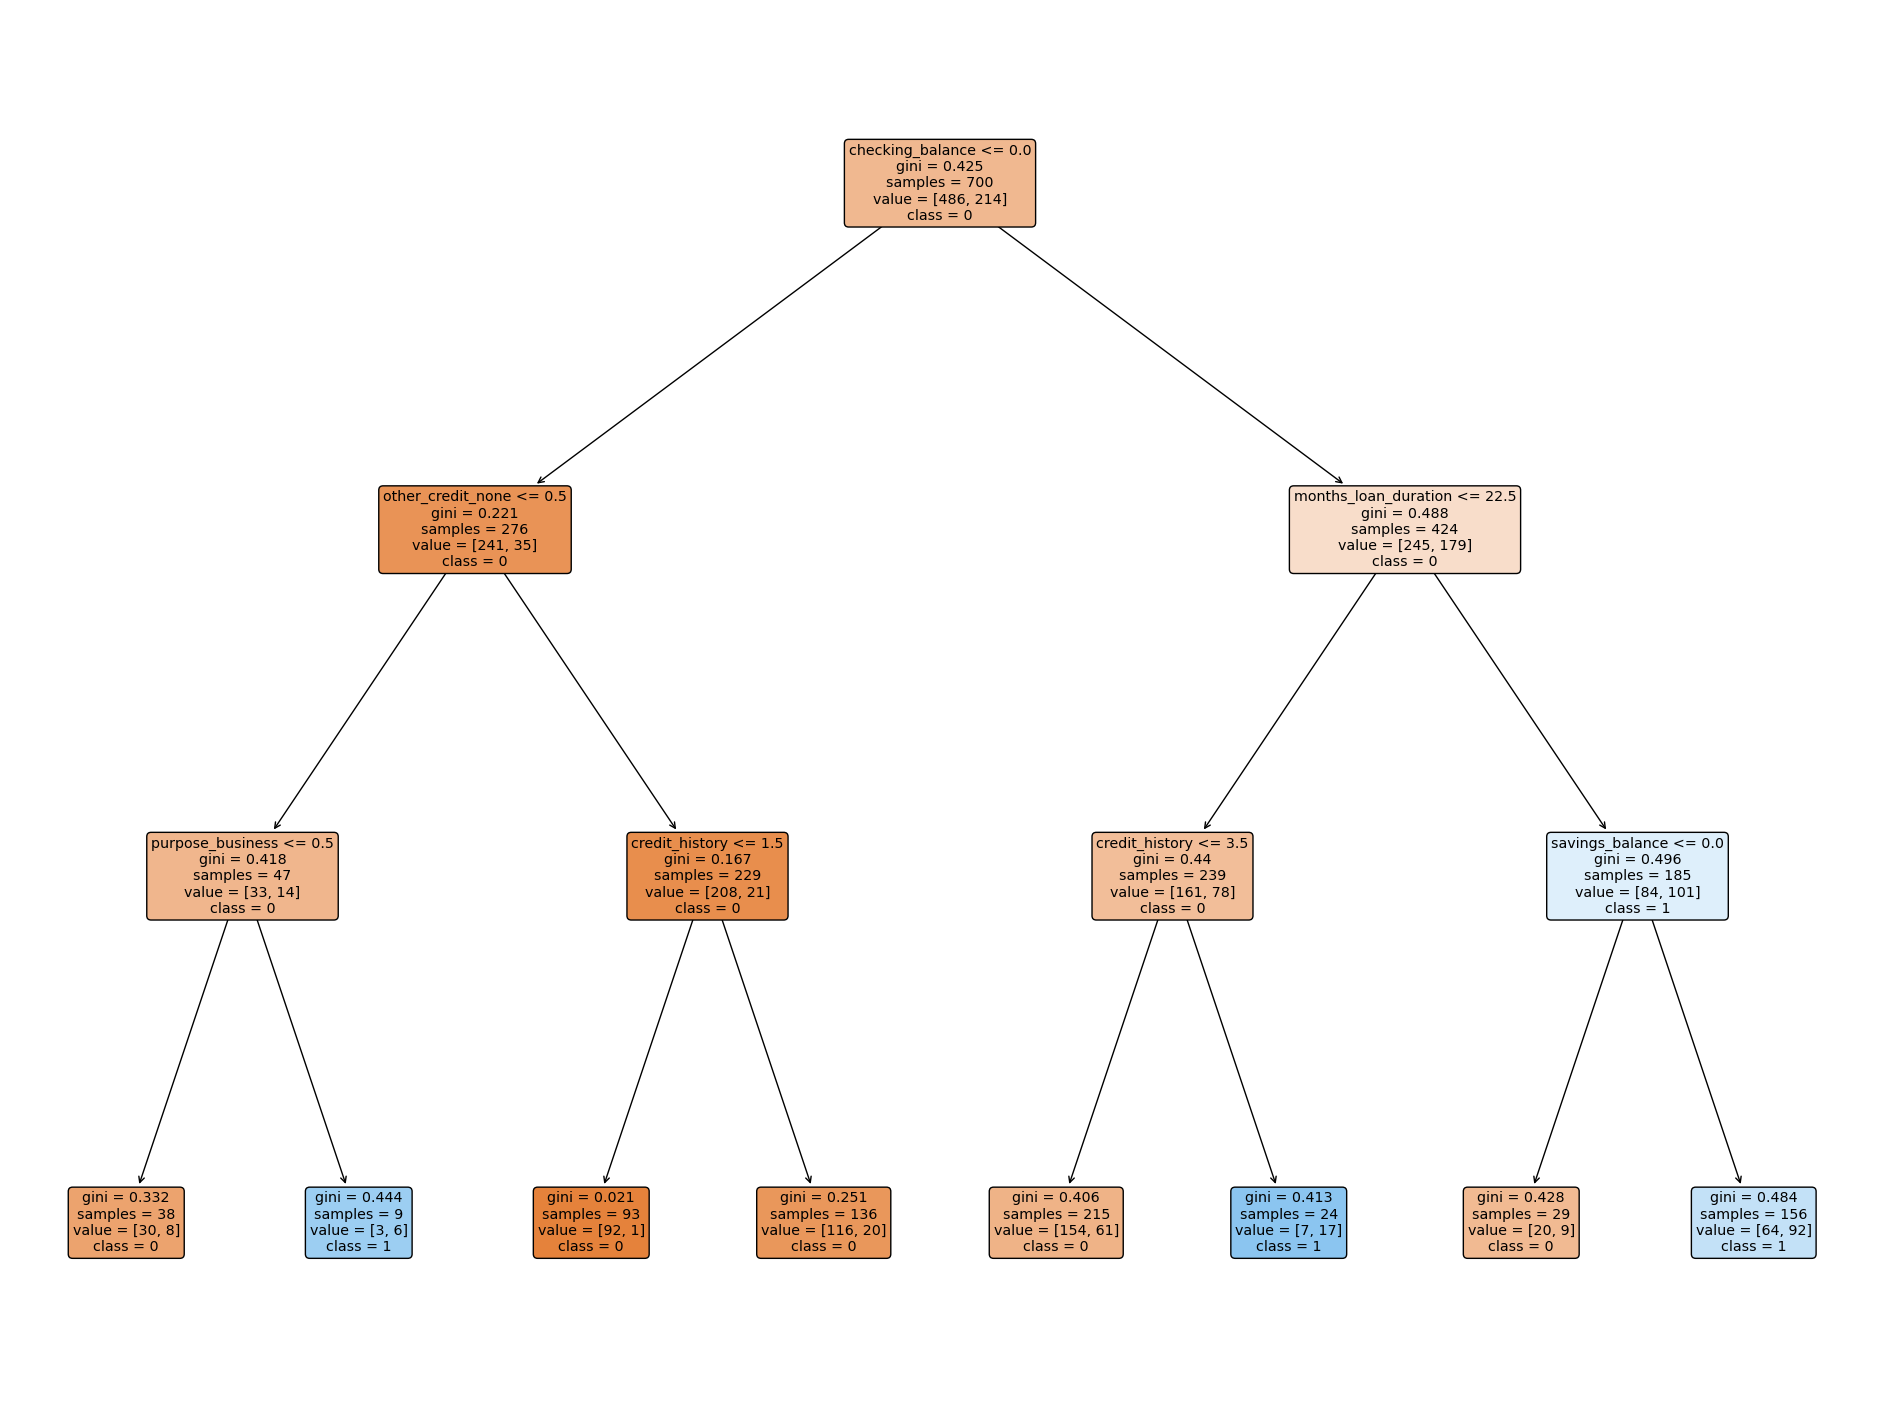

In [83]:
plt.figure(figsize=(24, 18))
plot_tree(dTree,feature_names=x.columns,class_names=["0","1"],filled=True,rounded=True)
plt.show()

#checking importance of features

In [85]:
pd.DataFrame(dTree.feature_importances_, columns = ["Imp"], index = x_train.columns)

,Imp
checking_balance,0.492510
months_loan_duration,0.169806
credit_history,0.166109
amount,0.000000
savings_balance,0.064467
employment_duration,0.000000
percent_of_income,0.000000
years_at_residence,0.000000
age,0.000000
existing_loans_count,0.000000


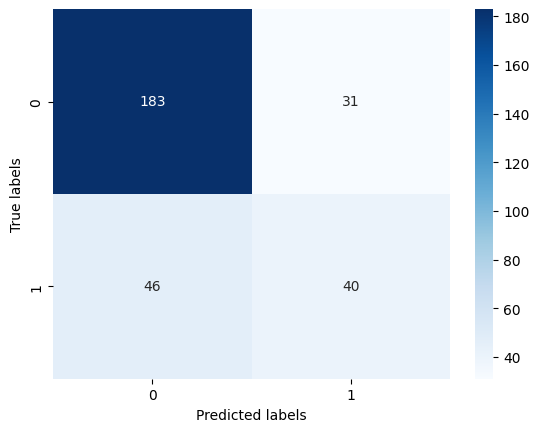

In [86]:
pred_y=dTree.predict(x_test)
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_y)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()